# Repeat Energy analysis
To test the viablilty of Julia, I tried to replicate the analysis I performed in my [gas usage article](https://medium.com/towards-data-science/does-my-new-central-heating-boiler-help-with-these-crazy-high-gas-prices-b238fd623bba). 

The input data for the analysis is an Excel file with my anonymous energy usage data, and a dataset from the KNMI listing temperature data. We read both datasets, aggregate them to weekly values, clean up the data and run it through a Linear regression model. 

## Read gas usage from Excel file
See [this link](https://felipenoris.github.io/XLSX.jl/stable/tutorial/#Read-Tabular-Data)

In [1]:
using StatsKit, DataFramesMeta, Dates, Gadfly, XLSX

gas_usage = DataFrame(XLSX.readtable("usage_anonymized.xlsx", "Sheet1", infer_eltypes = true))
first(gas_usage, 5)

5×5 DataFrame
 Row │ Datum       elec_low  elec_high  gas_usage  elec_usage
     │ Date        Any       Any        Any        Any
─────┼────────────────────────────────────────────────────────
   1 │ 2014-03-01  0.998766  0.998682   0.307692   0.999422
   2 │ 2014-03-02  0.99859   0.998682   0.384615   0.99934
   3 │ 2014-03-03  0.998149  0.999225   0.384615   0.999422
   4 │ 2014-03-04  0.998149  0.999302   0.307692   0.999463
   5 │ 2014-03-05  0.998061  0.999225   0.307692   0.999381

## Read weather data from text file

In [2]:
knmi_data = @chain "knmi_weather.txt" begin
    CSV.File(comment="#", header=["station", "Datum", "T_avg", "T_min", "T_max"], 
             dateformat="yyyymmdd", types=Dict(:Datum => Date))   
    DataFrame()
    @transform(:T_avg = :T_avg / 10, :T_min = :T_min / 10, :T_max = :T_max / 10)
end
first(knmi_data, 5)

5×5 DataFrame
 Row │ station  Datum       T_avg    T_min    T_max
     │ Int64    Date        Float64  Float64  Float64
─────┼────────────────────────────────────────────────
   1 │     280  2014-01-01      6.5      4.9      8.8
   2 │     280  2014-01-02      8.3      5.7     11.1
   3 │     280  2014-01-03      7.9      5.4     10.3
   4 │     280  2014-01-04      7.1      5.5      8.2
   5 │     280  2014-01-05      5.5      3.3      7.2

## Plot gas usage over time

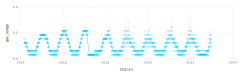

In [3]:
set_default_plot_size(24cm, 8cm)

@chain gas_usage begin
    Gadfly.plot(x=:Datum, y=:gas_usage, 
                Geom.point, 
                Geom.smooth(method=:loess,smoothing=0.03), 
                alpha=[0.1], Theme(highlight_width=0mm))
end

## Resample to weekly values, combine weather and gas usage

*Gas usage data*

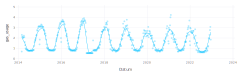

In [9]:
gas_usage_weekly = @chain gas_usage begin
    @transform(:week_id = Dates.week.(:Datum),
               :year_id = Dates.year.(:Datum))
    @by([:week_id, :year_id], :gas_usage=sum(:gas_usage), :Datum=:Datum[1], :no_days=size(:Datum)[1])
end

@chain gas_usage_weekly begin
    Gadfly.plot(x=:Datum, y=:gas_usage, 
                Geom.point, 
                Geom.smooth(method=:loess,smoothing=0.05), 
                alpha=[0.3], Theme(highlight_width=0mm))
end

*weather data*

In [ ]:
knmi_data_weekly_mean = @chain knmi_data begin
    @transform(:week_id = Dates.week.(:Datum),
               :year_id = Dates.year.(:Datum))
    @by([:week_id, :year_id], :T_avg=mean(:T_avg), :Datum=:Datum[1])
end
first(knmi_data_weekly_mean)

DataFrameRow
 Row │ week_id  year_id  T_avg    Datum
     │ Int64    Int64    Float64  Date
─────┼───────────────────────────────────────
   1 │       1     2014   6.0875  2014-01-01

*combine weather and gas_usage*

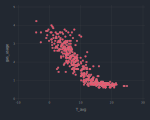

In [ ]:
joined_weekly_mean = @chain gas_usage_weekly begin
    innerjoin(knmi_data_weekly_mean, on=:Datum, makeunique=true)
    @subset(:gas_usage .>= 0.55)
end

set_default_plot_size(15cm, 12cm)
@chain joined_weekly_mean begin
    Gadfly.plot(x=:T_avg, y=:gas_usage, Geom.point)
end

### All operations in one go

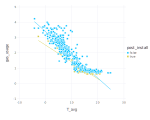

In [33]:
knmi_data = @chain "knmi_weather.txt" begin
    CSV.File(comment="#", header=["station", "Datum", "T_avg", "T_min", "T_max"], 
             dateformat="yyyymmdd", types=Dict(:Datum => Date))   
    DataFrame()
    @transform(:T_avg = :T_avg / 10, :T_min = :T_min / 10, :T_max = :T_max / 10,
               :week_id = Dates.week.(:Datum),
               :year_id = Dates.year.(:Datum))
    @by([:week_id, :year_id], :T_avg=mean(:T_avg),          # Aggregate to week
                              :Datum=:Datum[1])             # Append the first date of the week
end

joined_weekly_mean = @chain "usage_anonymized.xlsx" begin
    XLSX.readtable("Sheet1", infer_eltypes = true)
    DataFrame()
    @transform(:week_id = Dates.week.(:Datum),
               :year_id = Dates.year.(:Datum))
    @by([:week_id, :year_id], :gas_usage=sum(:gas_usage),   # Aggregate to week
                              :Datum=:Datum[1],             # Append the first date of the week
                              :no_days=size(:Datum)[1])     # Append no days present in this week
    innerjoin(knmi_data, on=:Datum, makeunique=true)
    @subset(:gas_usage .>= 0.55, :no_days .== 7)            # Eliminate some obvious faulty values and weeks that do not have the full 7 days
    @transform(:post_install = :Datum .> Date("2022-05"))
end

set_default_plot_size(15cm, 12cm)
@chain joined_weekly_mean begin
    Gadfly.plot(x=:T_avg, y=:gas_usage, color=:post_install, Geom.point, Geom.smooth(method=:lm))
end

In [32]:
using GLM

lm(@formula(gas_usage ~ T_avg * post_install), joined_weekly_mean)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gas_usage ~ 1 + T_avg + post_install + T_avg & post_install

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            3.39368    0.041646     81.49    <1e-99   3.31183     3.47554
T_avg                 -0.152191   0.00350507  -43.42    <1e-99  -0.15908    -0.145302
post_install          -0.889057   0.183482     -4.85    <1e-05  -1.24969    -0.528424
T_avg & post_install   0.0421465  0.0129811     3.25    0.0013   0.0166322   0.0676607
──────────────────────────────────────────────────────────────────────────────────────